# Telco Churn Project




## Why are our customers churning?
### Look for any groupings (if any) that indicate a customer is more likely to churn.

In [71]:
import pandas as pd
import numpy as np

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

# preparing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# acquiring
# from explore import anatomy_of_a_figure
from env import host, user, password
from pydataset import data

In [60]:
from acquire import get_db
from acquire import get_telco_data

In [61]:
df = get_telco_data()

In [62]:
df

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.90,542.4,No,Mailed check,DSL,Month-to-month
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,No,No,Yes,Yes,Yes,1,Yes,4,69.40,571.45,No,Credit card (automatic),DSL,Month-to-month
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,No,No,No,No,No,1,Yes,1,48.20,340.35,No,Electronic check,DSL,Month-to-month
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,No,No,No,No,No,1,Yes,1,25.10,25.1,Yes,Electronic check,DSL,Month-to-month
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,No,No,No,No,No,1,No,3,30.50,30.5,Yes,Bank transfer (automatic),DSL,Month-to-month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9950-MTGYX,Male,0,Yes,Yes,28,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,20.30,487.95,No,Credit card (automatic),None,Two year
7039,9953-ZMKSM,Male,0,No,No,63,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,No,2,25.25,1559.3,No,Mailed check,None,Two year
7040,9964-WBQDJ,Female,0,Yes,No,71,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,24.40,1725.4,No,Credit card (automatic),None,Two year
7041,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,3,19.25,1372.9,No,Bank transfer (automatic),None,Two year


In [63]:
#

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

In [64]:
# Pandas wasn't showing all the columns in the dataframe, so I expanded the number of default columns Pandas would display.
# Exocortext: https://www.mikulskibartosz.name/how-to-display-all-columns-of-a-pandas-dataframe-in-jupyter-notebook/

pd.set_option('display.max_columns', 999)

In [65]:
df

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.90,542.4,No,Mailed check,DSL,Month-to-month
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,No,No,Yes,Yes,Yes,1,Yes,4,69.40,571.45,No,Credit card (automatic),DSL,Month-to-month
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,No,No,No,No,No,1,Yes,1,48.20,340.35,No,Electronic check,DSL,Month-to-month
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,No,No,No,No,No,1,Yes,1,25.10,25.1,Yes,Electronic check,DSL,Month-to-month
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,No,No,No,No,No,1,No,3,30.50,30.5,Yes,Bank transfer (automatic),DSL,Month-to-month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9950-MTGYX,Male,0,Yes,Yes,28,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,20.30,487.95,No,Credit card (automatic),None,Two year
7039,9953-ZMKSM,Male,0,No,No,63,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,No,2,25.25,1559.3,No,Mailed check,None,Two year
7040,9964-WBQDJ,Female,0,Yes,No,71,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,24.40,1725.4,No,Credit card (automatic),None,Two year
7041,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,3,19.25,1372.9,No,Bank transfer (automatic),None,Two year


In [66]:
df[df.online_backup == 'Yes'].churn.value_counts()

No     1906
Yes     523
Name: churn, dtype: int64

In [67]:
df[df.online_security == 'Yes'].churn.value_counts()

No     1724
Yes     295
Name: churn, dtype: int64

In [68]:
df[df.online_backup == "Yes"].shape

(2429, 24)

# Prepare Data

#### Columns that I need to change to numerical:
- Gender --> new column "is_female" Female = 1, Male = 0
- online_security thru streaming_movies needs to be turned into a column of discreet variables.
- churn needs to be turned into a discreet variable column. Not churned = 0, churned = 1
- partner and dependents need to become discreet if I use them. 

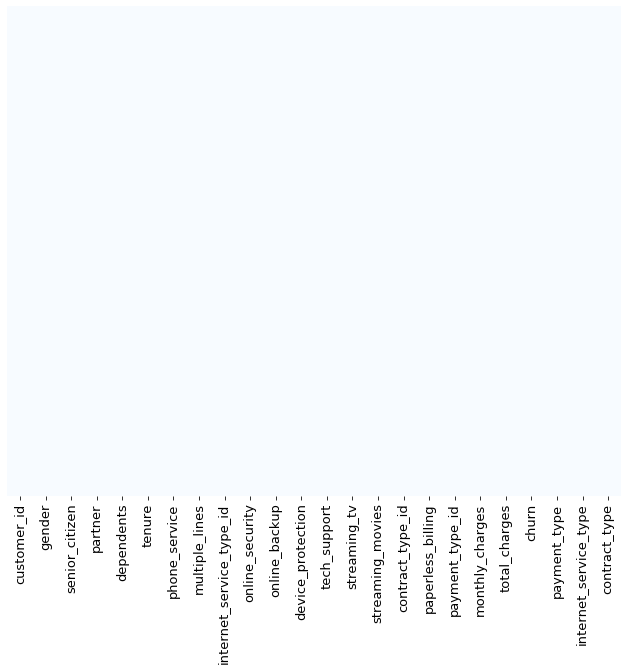

In [73]:
# A quick visualization technique using a heatmap shows there are no missing values in the columns. Meaning we have fairly clean data.

sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [74]:
# Further confirmation there are no missing values that need to be imputed.

df.isna().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
payment_type                0
internet_service_type       0
contract_type               0
dtype: int64

In [ ]:
# However, some of these value may need to be normalized/stratified depending on which columns I'll need to use.

# Exploratory Phase

In [69]:
# Want to find the overall churn rate across the entire customer base:

df.churn.value_counts(normalize = True)

# 26% of all customers churned last month, across the entire customer base.

No     0.73463
Yes    0.26537
Name: churn, dtype: float64